In [1]:
#图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模

In [2]:
#导入包
%matplotlib inline
import torch
from d2l import torch as d2l
from torch import nn
import torchvision

可以使用../../返回上上级目录

In [3]:
all_images=torchvision.datasets.CIFAR10(train=True,root="../../data",
                                        download=True)

Files already downloaded and verified


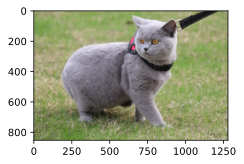

In [4]:
d2l.set_figsize()
img=d2l.Image.open("./cat.jpg")
d2l.plt.imshow(img)

In [5]:
img.size

(1280, 853)

In [6]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    d2l.show_images(Y,num_rows,num_cols,scale=scale)

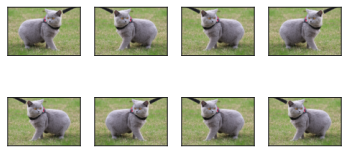

In [7]:
#左右翻转
apply(img,torchvision.transforms.RandomHorizontalFlip())

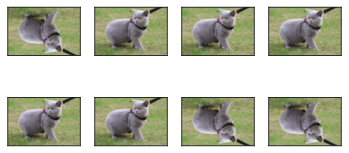

In [8]:
#上下翻转
apply(img,torchvision.transforms.RandomVerticalFlip())

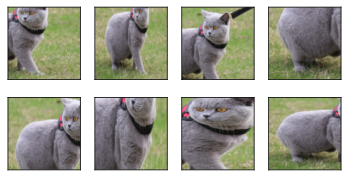

In [9]:
#随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。 然后，区域的宽度和高度都被缩放到200像素。

shape_aug=torchvision.transforms.RandomResizedCrop(
    size=(200,200),
    scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

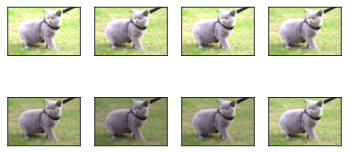

In [10]:
#改变颜色。 我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调，更改图像的亮度，随机值为原始图像的50%（
#）到150%（）之间。

apply(img,torchvision.transforms.ColorJitter(brightness=0.5,
                                             contrast=0,saturation=0,hue=0))

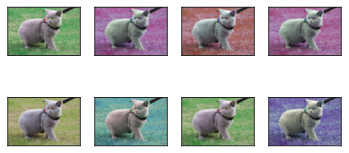

In [11]:
#更改色调
apply(img,torchvision.transforms.ColorJitter(brightness=0,contrast=0,
                                             saturation=0,hue=0.5))

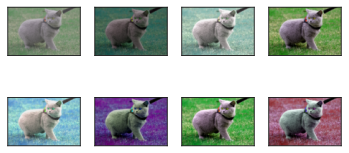

In [12]:
#创建一个RandomColorJitter实例，并设置如何同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。
color_aug=torchvision.transforms.ColorJitter(brightness=0.5,contrast=0.5,
                                             saturation=0.5,hue=0.5)

apply(img,color_aug)

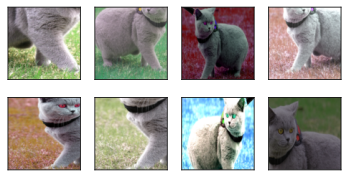

In [13]:
#结合多种图像增广方法

augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),color_aug,shape_aug
])
apply(img,augs)

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

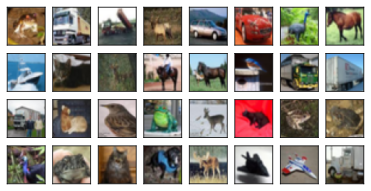

In [14]:
#使用图像增广进行训练 cifar10
all_images=torchvision.datasets.CIFAR10(root="../../data",train=True,download=True)

d2l.show_images([all_images[i][0] for i in range(32)],4,8,scale=0.8)


In [15]:
train_aug=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_aug=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [16]:
def load_cifar10(is_train,augs,batch_size):
    dataset=torchvision.datasets.CIFAR10(
        root="../../data",train=is_train,
        transform=augs,download=True)
    
    dataloader=torch.utils.data.DataLoader(dataset,batch_size,
                                           shuffle=is_train,num_workers=d2l.get_dataloader_workers())
    
    return dataloader

In [17]:
def train_batch_ch13(net,X,y,loss,trainer,devices):
    if isinstance(X,list):
        X=[x.to(devices[0]) for x in X]
    else:
        X=X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred=net(X)
    ls=loss(pred,y)
    ls.sum().backward()
    trainer.step()
    train_loss_sum=ls.sum()
    train_acc_sum=d2l.accuracy(pred,y)
    return train_loss_sum,train_acc_sum
    

In [18]:
def train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices=d2l.try_all_gpus()):
    timer,num_batches=d2l.Timer(),len(train_iter)
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],
                          legend=['train loss','train acc','test acc'])
    
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(4)
        for i,(feature,labels) in enumerate(train_iter):
            timer.start()
            l,acc=train_batch_ch13(
                net,feature,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(metric[0]/metric[2],metric[1]/metric[4],None))
            
            test_acc=d2l.evaluate_accuracy_gpu(net,test_iter)
            animator.add(epoch+1,(None,None,test_acc))

        print(f'loss:{matric[0]/metric[2]:.3f}, train acc:{metric[1]/metric[4]:.3f}, test acc:{test_acc:.3f}')

        print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')


In [19]:
batch_size,devices,net=256,d2l.try_all_gpus(),d2l.resnet18(10,3)
print(devices)
def init_weigths(m):
    if type(m) in [nn.Linear,nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weigths)

def train_with_data_aug(train_aug,test_aug,net,lr=0.001):
    train_iter=load_cifar10(True,train_aug,batch_size)
    test_iter=load_cifar10(False,test_aug,batch_size)
    loss=nn.CrossEntropyLoss(reduction='none')
    trainer=torch.optim.Adam(net.parameters(),lr)
    train_ch13(net,train_iter,test_iter,loss,trainer,10,devices)

[device(type='cuda', index=0)]


d:\Python\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [21]:
train_with_data_aug(train_aug,test_aug,net)

Files already downloaded and verified
Files already downloaded and verified
